## Importing Libraries

In [1]:
import pandas as pd
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import discrete_allocation
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import base_optimizer
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt.hierarchical_portfolio import HRPOpt

C:\Users\ruchd\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ruchd\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ruchd\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Getting the Data

In [2]:
# Define the ticker list
tickers_list = ['AAPL', 'WMT', 'MU', 'BA','GOOG','BABA','GE','AMD','BAC','GM','T','UAA','XOM','RRC','PFE','JPM','SBUX']

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list,'2015-6-1')['Adj Close']
#print(data.iloc[-1])
# Print first 5 rows of the data
#print(data.head())
#print(data.tail())

[*********************100%***********************]  17 of 17 completed


## Markowitz with Sharpe maximization

In [3]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
historical_prices = data
#target_volatility = 0.2


# Calculate expected returns
returns = expected_returns.mean_historical_return(historical_prices)
cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

# Efficient Frontier graph

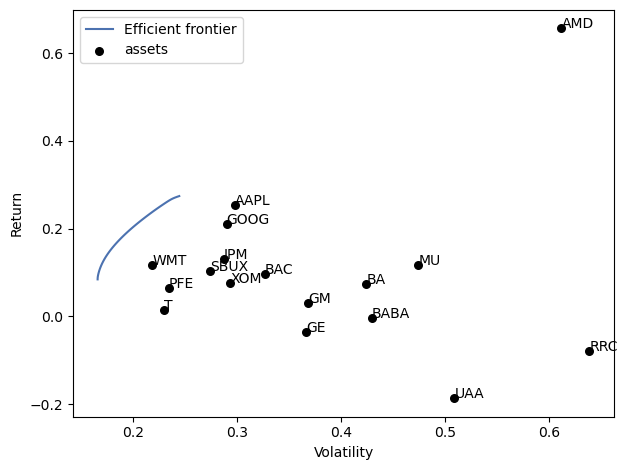

In [4]:
import pypfopt.plotting as plotting
import matplotlib.pyplot as plt
#import seaborn as sns

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef,ax=ax,show_assets=True, show_tickers = True)

plt.show()

In [5]:
# Optimize for maximum Sharpe ratio

#weights = ef.max_sharpe()

#  print weights
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.20001), ('AMD', 0.20002), ('BA', 0.0), ('BABA', 0.0), ('BAC', 0.0), ('GE', 0.0), ('GM', 0.0), ('GOOG', 0.2), ('JPM', 0.19807), ('MU', 0.0), ('PFE', 0.00194), ('RRC', 0.0), ('SBUX', 0.0), ('T', 0.0), ('UAA', 0.0), ('WMT', 0.2), ('XOM', 0.0)])


In [6]:
#to know the expected performance of the portfolio with optimal weights w
ef.portfolio_performance(verbose=True)

Expected annual return: 27.4%
Annual volatility: 24.5%
Sharpe Ratio: 1.04


(0.2742911299310116, 0.24471817000071477, 1.039118304661517)

In [7]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()

TypeError: latest_prices should be a pd.Series with no NaNs

In [ ]:
print("Optimal Allocation:", allocation)

## Markowitz with Target Volatility

In [ ]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
historical_prices = data
target_volatility = 0.2


# Calculate expected returns
returns = expected_returns.mean_historical_return(historical_prices)
cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef_tv = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

ef_tv.efficient_risk(target_volatility)

# Optimize for maximum Sharpe ratio
#weights = ef.max_sharpe()

#  print weights
cleaned_weights_tv = ef_tv.clean_weights()
print(cleaned_weights)

In [ ]:
#to know the expected performance of the portfolio with optimal weights w
ef_tv.portfolio_performance(verbose=True)

In [ ]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
da = DiscreteAllocation(cleaned_weights_tv, latest_prices, total_portfolio_value=10000)
allocation_tv, leftover = da.lp_portfolio()

In [ ]:
print("Optimal Allocation:", allocation_tv)

## Markowitz with Monthly Rebalancing keeping Original Weights Only

## Markowitz with Monthly Rebalancing - With Original Weights Revising every 12 months